In [ ]:
from IPython.display import clear_output
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d praveengovi/coronahack-chest-xraydataset
!unzip -q coronahack-chest-xraydataset.zip
!rm coronahack-chest-xraydataset.zip
!pip install -q plot_metric
clear_output()

In [ ]:
!cd ./Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train && ls -l

In [ ]:
!ls -l

total 340
-rw-r--r-- 1 root root    252 Mar 20  2020  Chest_xray_Corona_dataset_Summary.csv
-rw-r--r-- 1 root root 314074 Mar 20  2020  Chest_xray_Corona_Metadata.csv
drwxr-xr-x 3 root root   4096 Jan 17 20:59  Coronahack-Chest-XRay-Dataset
-rw-r--r-- 1 root root   6585 Jan 17 20:46  download
-rw-r--r-- 1 root root     67 Jan 17 20:55 'kaggle (1).json'
-rw-r--r-- 1 root root     67 Jan 17 20:59 'kaggle (2).json'
-rw-r--r-- 1 root root     67 Jan 17 20:52  kaggle.json
drwxr-xr-x 1 root root   4096 Jan  7 14:33  sample_data


In [ ]:
!cd ./Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/ && ls | wc -l
!cd ./Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/ && ls | wc -l

5309
624


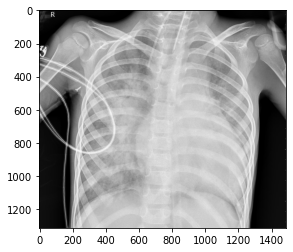

In [ ]:
import cv2
import matplotlib.pyplot as plt

img_path = r'./Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/person978_bacteria_2904.jpeg'

img = cv2.imread(img_path)
plt.imshow(img)

In [ ]:
import pandas as pd

labels_df = pd.read_csv('Chest_xray_Corona_Metadata.csv', index_col=0)
labels_df.head()
# map labels to integers

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [ ]:
labels_df.Dataset_type.value_counts()  # train, test subsets

TRAIN    5286
TEST      624
Name: Dataset_type, dtype: int64

In [ ]:
labels_df.Label.value_counts(normalize=True)

Pnemonia    0.733333
Normal      0.266667
Name: Label, dtype: float64

In [ ]:
labels_df.loc[labels_df['Dataset_type'] == 'TRAIN', 'Label'].value_counts(normalize=True)

Pnemonia    0.746122
Normal      0.253878
Name: Label, dtype: float64

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, datasets
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T
from torch import optim

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
from tqdm.notebook import tqdm

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, classification_report, auc

In [ ]:
# using CrossEntropyLoss is redundant, but we can extrapolate this notebook for multiclass easily
# just by editting labels vocabs, num_classes and removing roc_auc metric
# also obtain second csv table with multiple labels

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
train_folder = r'./Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/'
test_folder = r'./Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/'
data_root = r'Chest_xray_Corona_Metadata.csv'
model_name = input('Enter model name: ')

Enter model name: efficient5


In [ ]:
efficient_models = {'efficient0': [224, 1280, 'efficientnet_b0'],
                    'efficient4': [380, 1792, 'efficientnet_b4'],
                    'efficient5': [456, 2048, 'efficientnet_b5']
                    }

In [ ]:
labels_to_int = {'Pnemonia': 0, 'Normal': 1}
int_to_labels = {0: 'Pnemonia', 1: 'Normal'}

In [ ]:
IMAGE_SIZE = efficient_models.get(model_name)[0] if model_name.startswith('efficient') else 224
BATCH_SIZE = 32
epochs = 50
num_classes = 2
PATH = os.path.join(os.getcwd() + '/model_weights.pth')
torch.manual_seed(1)

In [ ]:
# full pipeline of transformations
train_transforms_full = T.Compose([
                                   T.ToPILImage(),
                                   T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                   #T.CenterCrop(IMAGE_SIZE),
                                   T.ColorJitter(brightness=(0.95, 1.05),
                                                 contrast=(0.95, 1.05),
                                                 saturation=(0.95, 1.05),
                                                 hue=0.0),  # 0.25
                                   T.RandomHorizontalFlip(p=0.1),
                                   T.GaussianBlur(kernel_size=(3, 5), sigma=(0.1, 2)),
                                   T.RandomAdjustSharpness(sharpness_factor=1.5, p=0.2),
                                   T.RandomRotation(degrees=(-10, 10)),
                                   T.ToTensor(),
                                   T.Normalize(mean=[0.485, 0.456, 0.406], 
                                               std=[0.229, 0.224, 0.225]),
])

# reduced pipeline of transformations
train_transforms = T.Compose([
                              T.ToPILImage(),
                              T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                              T.RandomApply(transforms=[T.RandomAffine(
                                                                       degrees=(-180, 180), 
                                                                       translate=(0.10, 0.10), 
                                                                       scale=(0.9, 1.10))], 
                                            p=0.99),
                              T.RandomHorizontalFlip(p=0.5),
                              T.ToTensor(),
                              T.Normalize(mean=[0.485, 0.456, 0.406], 
                                          std=[0.229, 0.224, 0.225])
])

valid_transforms = T.Compose([
                              T.ToPILImage(),
                              T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                              T.ToTensor(),
                              T.Normalize(mean=[0.485, 0.456, 0.406], 
                                          std=[0.229, 0.224, 0.225])
])

In [ ]:
labels_df = pd.read_csv(data_root, index_col=0)
train = labels_df.loc[labels_df['Dataset_type'] == 'TRAIN', ['X_ray_image_name', 'Label']]
test = labels_df.loc[labels_df['Dataset_type'] == 'TEST', ['X_ray_image_name', 'Label']]

X, y = train.drop('Label', axis=1), train['Label']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, shuffle=True, stratify=y, random_state=1)

train = pd.concat([X_train, y_train], axis=1)
valid = pd.concat([X_valid, y_valid], axis=1)

In [ ]:
# gives weights << 1
y_train_ = y_train.map(labels_to_int).values
class_sample_count = np.unique(y_train_, return_counts=True)[1]
weight = 1. / class_sample_count
samples_weight = weight[y_train_]
samples_weight = torch.from_numpy(samples_weight)
sampler_ = torch.utils.data.WeightedRandomSampler(samples_weight, len(samples_weight))

# gives weights > 1
class_counts = y_train.value_counts().to_list()
num_samples = sum(class_counts)
labels = y_train.map(labels_to_int).values

class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
weights = [class_weights[labels[i]] for i in range(int(num_samples))]
sampler = torch.utils.data.WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))

In [ ]:
class Covid(Dataset):
    def __init__(self, df, folder, transforms=None):
        self.df = df.copy()
        self.folder = folder
        self.transforms = transforms
        self.df['Label'] = self.df['Label'].map(labels_to_int)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, ix):
        row = self.df.iloc[ix].squeeze()
        img_name = row['X_ray_image_name']
        target = row['Label']
        img = cv2.imread(self.folder + img_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transforms is None:
            img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
            img = torch.tensor(img/255.)
            img = img.permute(2,0,1)
            img = T.Normalize(mean=[0.485, 0.456, 0.406], 
                              std=[0.229, 0.224, 0.225])(img)
            img = img.float().to(device)
            target = torch.tensor([target]).float().to(device)
        return img, target

    def collate_fn(self, batch):
        imgs, targets = list(zip(*batch))
        if self.transforms is not None:
            imgs = [self.transforms(img)[None] for img in imgs]
            targets = [torch.tensor([tar]) for tar in targets]
        imgs, targets = [torch.cat(i).to(device) for i in [imgs, targets]]
        return imgs, targets

In [ ]:
# also apply for imbalanced:
# augmented images concstenated with plain images
# SMOTE by mini-batches

In [ ]:
train_ds = Covid(df=train, folder=train_folder, transforms=train_transforms_full)
# train_ds = Covid(df=train, folder=train_folder, transforms=train_transforms)

valid_ds = Covid(df=valid, folder=train_folder, transforms=valid_transforms)
test_ds = Covid(df=test, folder=test_folder, transforms=valid_transforms)

In [ ]:
# without sampler
# train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=train_ds.collate_fn, drop_last=True)

# train shuffle=False with sampler
# sampler_ for small weights (preferable), sampler for ordinal weights
train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False, sampler=sampler_, collate_fn=train_ds.collate_fn, drop_last=True)
valid_dataloader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=valid_ds.collate_fn, drop_last=True)
test_dataloader = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=test_ds.collate_fn)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


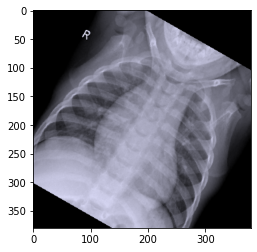

In [ ]:
# inverse normalize to observe the random transformations
for p in train_dataloader:
    img, _ = p
    img = img[np.random.randint(len(img)), ...]
    img = T.Normalize(
                      mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                      std=[1/0.229, 1/0.224, 1/0.255]
                     )(img)
    plt.imshow(img.permute(1,2,0).cpu().numpy())
    plt.show()
    break

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, path=PATH):
        self.path = path
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            torch.save(model.state_dict(), self.path)
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [ ]:
def get_model(use_all_params=False, model_type='vgg'):
    if model_type == 'vgg':
        model = models.vgg16(pretrained=True)
    elif model_type == 'resnet':
        model = models.resnet18(pretrained=True)

    if not use_all_params:
        for param in model.parameters():
            param.requires_grad = False
    """ alternative avgpool
    model.avgpool = nn.Sequential(nn.Conv2d(512,512,3),
                                  nn.MaxPool2d(2),
                                  nn.Flatten(),
                                  nn.Linear(2048, 512))
    """
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(512, 128),
        nn.BatchNorm1d(128), #
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(128, 64),
        nn.BatchNorm1d(64), #
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(64, num_classes), 
    )
    if model_type == 'vgg':
        model.classifier = classifier
    elif model_type == 'resnet':
        model.fc = classifier
    print(model.__class__.__name__)
    return model.to(device)

def get_efficient_model(use_all_params=False, partial_unfreeze=True, n_layers=20, model_name=model_name):
    model = eval('models.' + efficient_models.get(model_name)[2] + '(pretrained=True)')
    num_inputs = efficient_models.get(model_name)[1]
    #model = models.efficientnet_b4(pretrained=True)
    if not use_all_params:
        for param in model.parameters():
            param.requires_grad = False
        if partial_unfreeze:
            for name, child in list(model.features.named_modules())[-n_layers:]:
                if not isinstance(child, nn.BatchNorm2d):
                    for param in child.parameters():
                        param.requires_grad = True
    num_first_output = 625 if model_name == 'efficient0' or model_name == 'efficient4' else 1024
    model.classifier = nn.Sequential(
        nn.Linear(num_inputs, num_first_output),
        #nn.BatchNorm1d(num_first_output),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(num_first_output, 256),
        #nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, num_classes), 
    )
    return model.to(device)

class CovidModel(nn.Module):
    def __init__(self, model=None, use_all_params=False, model_type='vgg'):
        super(CovidModel, self).__init__()
        if model is None:
            self.model = get_model(use_all_params, model_type=model_type)
        else:
            self.model = model

    def forward(self, x):
        return self.model(x)

In [ ]:
model = CovidModel(model=get_efficient_model(partial_unfreeze=False)) if model_name.startswith('efficient') else CovidModel(model_type='resnet', use_all_params=True)

In [ ]:
# optional uncomment to simplify model fc layers
# model.classifier = nn.Linear(1792, num_classes) if model_name == 'efficient' else nn.Linear(512, num_classes)
# model.fc = nn.Linear(512, num_classes)

In [ ]:
from torchsummary import summary
summary(model, (3,IMAGE_SIZE,IMAGE_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 48, 228, 228]           1,296
       BatchNorm2d-2         [-1, 48, 228, 228]              96
              SiLU-3         [-1, 48, 228, 228]               0
            Conv2d-4         [-1, 48, 228, 228]             432
       BatchNorm2d-5         [-1, 48, 228, 228]              96
              SiLU-6         [-1, 48, 228, 228]               0
 AdaptiveAvgPool2d-7             [-1, 48, 1, 1]               0
            Conv2d-8             [-1, 12, 1, 1]             588
              SiLU-9             [-1, 12, 1, 1]               0
           Conv2d-10             [-1, 48, 1, 1]             624
          Sigmoid-11             [-1, 48, 1, 1]               0
SqueezeExcitation-12         [-1, 48, 228, 228]               0
           Conv2d-13         [-1, 24, 228, 228]           1,152
      BatchNorm2d-14         [-1, 24, 2

In [ ]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_), y=y_train_)
class_weights = torch.from_numpy(class_weights)
class_weights = class_weights.type(torch.float32)
class_weights

tensor([0.6702, 1.9689])

In [ ]:
# weighted CrossEntropyLoss, uncomment if apply class weights
# criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, min_lr=1e-6, factor=0.1)
early_stop = EarlyStopping()

In [ ]:
def train_one_batch(model, data, optimizer, criterion, regularization=True):
    model.train()
    imgs, labels = data
    preds = model(imgs)

    l2_regularization = 0
    if regularization:
        for param in model.parameters():
            l2_regularization += torch.norm(param, 2)
    
    optimizer.zero_grad()
    loss = criterion(preds, labels) + 0.01 * l2_regularization
    loss.backward()
    optimizer.step()

    predicted_labels = torch.max(preds, 1)[1].cpu().numpy()
    true_labels = labels.cpu().numpy()
    probabilities = nn.Softmax(dim=1)(preds)[:, 1].cpu().detach().numpy()

    return loss.item(), predicted_labels, true_labels, probabilities

@torch.no_grad()
def validate(model, data, criterion):
    model.eval()
    imgs, labels = data
    preds = model(imgs)
    loss = criterion(preds, labels)

    predicted_labels = torch.max(preds, 1)[1].cpu().numpy()
    true_labels = labels.cpu().numpy()
    probabilities = nn.Softmax(dim=1)(preds)[:, 1].cpu().numpy()

    return loss.item(), predicted_labels, true_labels, probabilities

In [ ]:
train_losses, valid_losses = [], []
for epoch in range(epochs):

    print(f'Epoch {epoch + 1}/{epochs}')
    epoch_train_losses, epoch_valid_losses = [], []
    predicted_epoch_labels, true_epoch_labels, predicted_epoch_probas = np.array([]), np.array([]), np.array([])

    for i, batch in enumerate(tqdm(train_dataloader, leave=False)):
        batch_train_loss, predicted_labels, true_labels, probs = train_one_batch(model, batch, optimizer, 
                                                                                 criterion, regularization=False)
        epoch_train_losses.append(batch_train_loss)
        predicted_epoch_labels = np.append(predicted_epoch_labels, predicted_labels)
        predicted_epoch_probas = np.append(predicted_epoch_probas, probs)
        true_epoch_labels = np.append(true_epoch_labels, true_labels)
    epoch_train_loss = np.array(epoch_train_losses).mean()
    train_losses.append(epoch_train_loss)
    f1_train_epoch = f1_score(true_epoch_labels, predicted_epoch_labels, average='weighted')
    accuracy_train_epoch = (true_epoch_labels == predicted_epoch_labels).mean()
    roc_auc_train_epoch = roc_auc_score(true_epoch_labels, predicted_epoch_probas, average='weighted')
    print(f'Train loss: {epoch_train_loss:.4f}, train F-score: {f1_train_epoch:.4f}, train roc_auc: {roc_auc_train_epoch:.4f}')
    print(f'Train accuracy: {accuracy_train_epoch:.4f}')

    predicted_epoch_labels, true_epoch_labels, predicted_epoch_probas = np.array([]), np.array([]), np.array([])
    for i, batch in enumerate(tqdm(valid_dataloader, leave=False)):
        batch_valid_loss, predicted_labels, true_labels, probs = validate(model, batch, criterion)
        epoch_valid_losses.append(batch_valid_loss)
        predicted_epoch_labels = np.append(predicted_epoch_labels, predicted_labels)
        predicted_epoch_probas = np.append(predicted_epoch_probas, probs)
        true_epoch_labels = np.append(true_epoch_labels, true_labels)
    epoch_valid_loss = np.array(epoch_valid_losses).mean()
    valid_losses.append(epoch_valid_loss)
    f1_valid_epoch = f1_score(true_epoch_labels, predicted_epoch_labels, average='weighted')
    roc_auc_valid_epoch = roc_auc_score(true_epoch_labels, predicted_epoch_probas, average='weighted')
    accuracy_valid_epoch = (true_epoch_labels == predicted_epoch_labels).mean()
    print(f'Valid loss: {epoch_valid_loss:.4f}, valid F-score: {f1_valid_epoch:.4f}, valid roc_auc: {roc_auc_valid_epoch:.4f}')
    print(f'Valid accuracy: {accuracy_valid_epoch:.4f}')
    print('-'*50)    

    scheduler.step(epoch_valid_loss)
    early_stop(epoch_valid_loss, model)  # we can input here one of the metrics instead, but it is useless
    if early_stop.early_stop:
        print(f'Validation loss did not improve for {early_stop.patience} epochs. Training stopped.')
        model.load_state_dict(torch.load(PATH))
        break

Epoch 1/50


  0%|          | 0/148 [00:00<?, ?it/s]

Train loss: 0.2397, train F-score: 0.9050, train roc_auc: 0.9655
Train accuracy: 0.9050


  0%|          | 0/16 [00:00<?, ?it/s]

Valid loss: 0.1811, valid F-score: 0.9464, valid roc_auc: 0.9822
Valid accuracy: 0.9453
--------------------------------------------------
Epoch 2/50


  0%|          | 0/148 [00:00<?, ?it/s]

Train loss: 0.1805, train F-score: 0.9293, train roc_auc: 0.9794
Train accuracy: 0.9293


  0%|          | 0/16 [00:00<?, ?it/s]

Valid loss: 0.1545, valid F-score: 0.9418, valid roc_auc: 0.9825
Valid accuracy: 0.9414
--------------------------------------------------
Epoch 3/50


  0%|          | 0/148 [00:00<?, ?it/s]

Train loss: 0.1726, train F-score: 0.9345, train roc_auc: 0.9814
Train accuracy: 0.9345


  0%|          | 0/16 [00:00<?, ?it/s]

Valid loss: 0.2261, valid F-score: 0.9188, valid roc_auc: 0.9777
Valid accuracy: 0.9160
--------------------------------------------------
INFO: Early stopping counter 1 of 5
Epoch 4/50


  0%|          | 0/148 [00:00<?, ?it/s]

Train loss: 0.1597, train F-score: 0.9445, train roc_auc: 0.9832
Train accuracy: 0.9445


  0%|          | 0/16 [00:00<?, ?it/s]

Valid loss: 0.1555, valid F-score: 0.9425, valid roc_auc: 0.9804
Valid accuracy: 0.9414
--------------------------------------------------
INFO: Early stopping counter 2 of 5
Epoch 5/50


  0%|          | 0/148 [00:00<?, ?it/s]

Train loss: 0.1643, train F-score: 0.9367, train roc_auc: 0.9826
Train accuracy: 0.9367


  0%|          | 0/16 [00:00<?, ?it/s]

Valid loss: 0.1485, valid F-score: 0.9405, valid roc_auc: 0.9843
Valid accuracy: 0.9395
--------------------------------------------------
Epoch 6/50


  0%|          | 0/148 [00:00<?, ?it/s]

Train loss: 0.1549, train F-score: 0.9440, train roc_auc: 0.9845
Train accuracy: 0.9440


  0%|          | 0/16 [00:00<?, ?it/s]

Valid loss: 0.1971, valid F-score: 0.9191, valid roc_auc: 0.9844
Valid accuracy: 0.9160
--------------------------------------------------
INFO: Early stopping counter 1 of 5
Epoch 7/50


  0%|          | 0/148 [00:00<?, ?it/s]

Train loss: 0.1493, train F-score: 0.9442, train roc_auc: 0.9858
Train accuracy: 0.9443


  0%|          | 0/16 [00:00<?, ?it/s]

Valid loss: 0.2248, valid F-score: 0.9320, valid roc_auc: 0.9854
Valid accuracy: 0.9297
--------------------------------------------------
INFO: Early stopping counter 2 of 5
Epoch 8/50


  0%|          | 0/148 [00:00<?, ?it/s]

Train loss: 0.1552, train F-score: 0.9392, train roc_auc: 0.9848
Train accuracy: 0.9392


  0%|          | 0/16 [00:00<?, ?it/s]

Valid loss: 0.1749, valid F-score: 0.9298, valid roc_auc: 0.9844
Valid accuracy: 0.9277
--------------------------------------------------
INFO: Early stopping counter 3 of 5
Epoch 9/50


  0%|          | 0/148 [00:00<?, ?it/s]

Train loss: 0.1360, train F-score: 0.9499, train roc_auc: 0.9873
Train accuracy: 0.9500


  0%|          | 0/16 [00:00<?, ?it/s]

Valid loss: 0.1445, valid F-score: 0.9443, valid roc_auc: 0.9851
Valid accuracy: 0.9434
--------------------------------------------------
Epoch 10/50


  0%|          | 0/148 [00:00<?, ?it/s]

Train loss: 0.1520, train F-score: 0.9453, train roc_auc: 0.9842
Train accuracy: 0.9453


  0%|          | 0/16 [00:00<?, ?it/s]

Valid loss: 0.1600, valid F-score: 0.9406, valid roc_auc: 0.9816
Valid accuracy: 0.9395
--------------------------------------------------
INFO: Early stopping counter 1 of 5
Epoch 11/50


  0%|          | 0/148 [00:00<?, ?it/s]

Train loss: 0.1308, train F-score: 0.9540, train roc_auc: 0.9888
Train accuracy: 0.9540


  0%|          | 0/16 [00:00<?, ?it/s]

Valid loss: 0.1950, valid F-score: 0.9352, valid roc_auc: 0.9844
Valid accuracy: 0.9336
--------------------------------------------------
INFO: Early stopping counter 2 of 5
Epoch 12/50


  0%|          | 0/148 [00:00<?, ?it/s]

Train loss: 0.1529, train F-score: 0.9453, train roc_auc: 0.9848
Train accuracy: 0.9453


  0%|          | 0/16 [00:00<?, ?it/s]

Valid loss: 0.1528, valid F-score: 0.9390, valid roc_auc: 0.9855
Valid accuracy: 0.9375
--------------------------------------------------
INFO: Early stopping counter 3 of 5
Epoch 13/50


  0%|          | 0/148 [00:00<?, ?it/s]

Train loss: 0.1377, train F-score: 0.9483, train roc_auc: 0.9874
Train accuracy: 0.9483


  0%|          | 0/16 [00:00<?, ?it/s]

Valid loss: 0.1551, valid F-score: 0.9428, valid roc_auc: 0.9875
Valid accuracy: 0.9414
--------------------------------------------------
INFO: Early stopping counter 4 of 5
Epoch 14/50


  0%|          | 0/148 [00:00<?, ?it/s]

Train loss: 0.1256, train F-score: 0.9523, train roc_auc: 0.9903
Train accuracy: 0.9523


  0%|          | 0/16 [00:00<?, ?it/s]

Valid loss: 0.1497, valid F-score: 0.9446, valid roc_auc: 0.9874
Valid accuracy: 0.9434
--------------------------------------------------
INFO: Early stopping counter 5 of 5
INFO: Early stopping
Validation loss did not improve for 5 epochs. Training stopped.


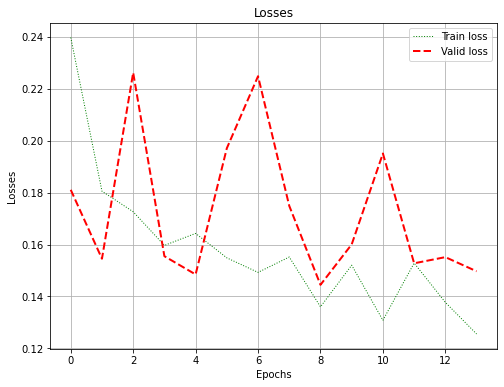

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Losses')
plt.plot(train_losses, ls=':', c='g', lw=1, label='Train loss')
plt.plot(valid_losses, ls='--', c='r', lw=2, label='Valid loss')
plt.xlabel('Epochs')
plt.ylabel('Losses')
#plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

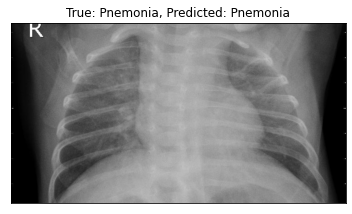

In [ ]:
data = test_ds[np.random.randint(len(test_ds))]
image, label = data
image_ = valid_transforms(image)[None].to(device)
prediction = model(image_)
pred_label = torch.max(prediction, 1)[1].cpu().numpy()
plt.title(f'True: {int_to_labels[int(label)]}, Predicted: {int_to_labels[int(pred_label)]}')
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
test_true_labels, test_pred_labels, test_pred_probas = [], [], []
with torch.no_grad():
    model.eval()
    for batch in test_dataloader:
        img, tar = batch
        pred = model(img)
        pred_ = torch.max(pred, 1)[1]
        probability = nn.Softmax(dim=1)(pred)[:, 1].cpu().numpy()
        test_true_labels.append(int(tar))
        test_pred_labels.append(int(pred_.cpu().numpy()))
        test_pred_probas.append(float(probability))
print(classification_report(test_true_labels, test_pred_labels, digits=3))
print(f'roc_auc: {roc_auc_score(test_true_labels, test_pred_probas, average="weighted"):.4f}')

              precision    recall  f1-score   support

           0      0.836     0.979     0.902       390
           1      0.952     0.679     0.793       234

    accuracy                          0.867       624
   macro avg      0.894     0.829     0.848       624
weighted avg      0.879     0.867     0.861       624

roc_auc: 0.9599


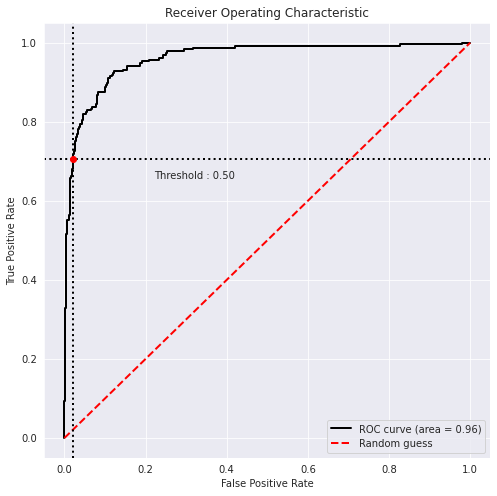

In [ ]:
from plot_metric.functions import BinaryClassification

bc = BinaryClassification(test_true_labels, test_pred_probas, labels=["Class 1", "Class 2"])
plt.figure(figsize=(8,8))
bc.plot_roc_curve()
plt.show()

  without class-weights and batchnorm1d, weight_decay$=1e-3$, initial transforms (see BCE notebook), efficient_b4 model, wrong auc (on labels)

    precision    recall  f1-score   support

           0      0.888     0.954     0.920       390
           1      0.912     0.799     0.852       234

    accuracy                          0.896       624
    macro avg      0.900     0.876    0.886       624
    weighted avg   0.897     0.896    0.894       624

    roc_auc: 0.8765

We may also use focal-loss instead of CrossEntropy (BCE) to get more accuarte results in case of imbalanced data for classification:


```
def sigmoid_focal_loss(inputs: torch.Tensor,
                       targets: torch.Tensor,
                       alpha: float = 0.25,
                       gamma: float = 2,
                       reduction: str = "none",):
    """
    Original implementation from https://github.com/facebookresearch/fvcore/blob/master/fvcore/nn/focal_loss.py .
    Loss used in RetinaNet for dense detection: https://arxiv.org/abs/1708.02002.

    Args:
        inputs: A float tensor of arbitrary shape.
                The predictions for each example.
        targets: A float tensor with the same shape as inputs. Stores the binary
                classification label for each element in inputs
                (0 for the negative class and 1 for the positive class).
        alpha: (optional) Weighting factor in range (0,1) to balance
                positive vs negative examples or -1 for ignore. Default = 0.25
        gamma: Exponent of the modulating factor (1 - p_t) to
               balance easy vs hard examples.
        reduction: 'none' | 'mean' | 'sum'
                 'none': No reduction will be applied to the output.
                 'mean': The output will be averaged.
                 'sum': The output will be summed.
    Returns:
        Loss tensor with the reduction option applied.
    """
    if not torch.jit.is_scripting() and not torch.jit.is_tracing():
        _log_api_usage_once(sigmoid_focal_loss)
    p = torch.sigmoid(inputs)
    ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
    p_t = p * targets + (1 - p) * (1 - targets)
    loss = ce_loss * ((1 - p_t) ** gamma)

    if alpha >= 0:
        alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
        loss = alpha_t * loss

    if reduction == "mean":
        loss = loss.mean()
    elif reduction == "sum":
        loss = loss.sum()

    return loss

```

